# Importing Libraries

In [4]:
import tensorflow as tf

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.debugging.set_log_device_placement(True)

In [8]:
# Enable device placement logging
tf.debugging.set_log_device_placement(True)

# Create a simple TensorFlow operation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [1]:
import numpy as np
import pandas as pd
import cv2
import os
# from patchify import patchify
from PIL import Image
from matplotlib import pyplot as plt
import tifffile
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.models import load_model
from tensorflow import keras

ModuleNotFoundError: No module named 'pandas'

# Stacking and saving Images

In [2]:
# DIRECTORY = (r"C:\Users\tause\Advance_ANN\data")

# CATEGORIES = []
# for classes in os.listdir(DIRECTORY):
#     CATEGORIES += [classes]

# data = np.zeros((512,512,31))
# i=0
# for category in CATEGORIES:
#     path = os.path.join(DIRECTORY, category)
#     path = path + '\\' + CATEGORIES[i]
# #     print(path)
#     j=0
#     for img in os.listdir(path):
#         if(img==("Thumbs.db") or img==((CATEGORIES[i][:-2])+"RGB.bmp")):
#             continue
#         img_path = os.path.join(path, img)
#         arr = cv2.imread(img_path,0)
#         data[:,:,j] = arr
#         j+=1
# #     images = [Image.fromarray(data[:, :, i].astype('uint8')) for i in range(data.shape[2])]
# #     images[0].save((r"C:\Users\tause\Advance_ANN\Stacked\\")+(CATEGORIES[i][:-2]+"stacked.tiff"), format='TIFF', save_all=True, append_images=images[1:])
#     i+=1


In [3]:
# data.shape

In [4]:
# plt.imshow(data[:,:,3],cmap='gray')

# Reading Stacked Images

In [9]:
DIRECTORY = (r"C:\Users\tause\Advance_ANN\Stacked")


CATEGORIES = []
for classes in os.listdir(DIRECTORY):
    CATEGORIES += [classes]

# print(CATEGORIES)

data = []
i=0
for category in CATEGORIES:
    img_path = os.path.join(DIRECTORY, category)
    arr = cv2.imread(img_path,0)
    data.append(arr)

stacked = np.array(data)

In [10]:
stacked = np.transpose(stacked, (1, 2, 0))
stacked.shape

(512, 512, 32)

# Making Patches

In [11]:
def extract_blocks(image, block_size, stride):
    blocks = []
    image_height, image_width = image.shape[:2]
    num_blocks_x = image_width // stride
    num_blocks_y = image_height // stride
    for y in range(0,image_height-block_size[1]+1,stride):
        for x in range(0,image_width-block_size[0]+1,stride):
            block=image[y:y+block_size[1],x:x+block_size[0]]
            blocks.append(block)
    return blocks

In [12]:
def reconstruct_image(patches, image_size, block_size, stride):
    # Get patch size
    patch_size = block_size[0]

    # Calculate the number of patches in each direction
    n_patches_x = (image_size[1] - patch_size) // stride + 1
    n_patches_y = (image_size[0] - patch_size) // stride + 1

    # Initialize reconstructed image
    reconstructed_image = np.zeros(image_size)

    # Place patches in the reconstructed image
    patch_idx = 0
    for y in range(n_patches_y):
        for x in range(n_patches_x):
            patch = patches[patch_idx]
            reconstructed_image[y*stride:y*stride+patch_size, x*stride:x*stride+patch_size] = patch
            patch_idx += 1

    return reconstructed_image

In [13]:
patches = np.array(extract_blocks(stacked,(64,64),24))
len(patches)

361

In [14]:
# plt.imshow(stacked[:,:,2],cmap="gray")


In [15]:
# for i in range(361):
#     plt.subplot(19,19,i+1)
#     fig = plt.imshow(patches[i,:,:,2],cmap='gray')
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)

In [16]:
orignal_image = reconstruct_image(patches = patches, image_size= stacked.shape, block_size = (64, 64),stride = 24)

In [17]:
orignal_image.shape

(512, 512, 32)

In [18]:
# plt.imshow(orignal_image[:,:,2],cmap="gray")

# Labels

In [19]:
y = np.array(patches)
y.shape

(361, 64, 64, 32)

In [20]:
y = y.astype(float)

# Making Dataset

In [21]:
x1 = tf.keras.layers.AveragePooling2D(pool_size=(8, 8),strides=(8, 8), padding='valid',dtype='float64')
x1 = x1(y)
x1.shape

TensorShape([361, 8, 8, 32])

In [22]:
x2_1 = y[:,:,:,0:11].mean(axis = 3)
x2_2 = y[:,:,:,11:22].mean(axis = 3)
x2_3 = y[:,:,:,22:].mean(axis = 3)

In [23]:
x2 = np.concatenate([np.expand_dims(x2_1,3),np.expand_dims(x2_2,3),np.expand_dims(x2_3,3)],axis = 3)
x2.shape

(361, 64, 64, 3)

# PreProcessing for Model

In [24]:
print("Labels-shape",y.shape)
print("Input_Feature-1 shape",x1.shape)
print("Input_Feature-2 shape",x2.shape)

Labels-shape (361, 64, 64, 32)
Input_Feature-1 shape (361, 8, 8, 32)
Input_Feature-2 shape (361, 64, 64, 3)


# Reshaping

In [25]:
# labels = layers.Flatten(dtype='float64')(y)
# print(labels.shape)
# feat1 = layers.Flatten(dtype='float64')(x1)
# print(feat1.shape)
# feat2 = layers.Flatten(dtype='float64')(x2)
# print(feat2.shape)

In [26]:
X_interploated = tf.image.resize(x1, (64, 64), method='bilinear')
X_interploated.shape

TensorShape([361, 64, 64, 32])

In [27]:
X = tf.concat([X_interploated, x2], axis=-1)
X.shape

TensorShape([361, 64, 64, 35])

In [28]:
X = X/255
y = y/255

# Standardization

In [29]:
# labels = labels/255
# feat1 = feat1/255
# feat2 = feat2/255

In [30]:
# feat_all = np.zeros((225,(np.array(feat1.shape[1])+np.array(feat2.shape[1]))))
# feat_all.shape

In [ ]:
# feat_all[:,0:np.array(feat1.shape[1])] = feat1
# feat_all[:,np.array(feat1.shape[1]):] = feat2

In [ ]:
# print(feat_all.shape)
# print(labels.shape)

# Model

In [ ]:
# model = tf.keras.Sequential(
#     [
#         layers.Input(shape=(14336,)),
#         layers.Dense(1024, activation="relu"),
#         layers.Dense(512, activation="relu"),
#         layers.Dense(512, activation="relu"),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(128, activation="relu"),
#         layers.Dense(64, activation="relu"),
#         layers.Dense(32, activation="relu"),
#         layers.Dense(131072,activation='sigmoid'),
#     ]
# )

In [ ]:
# model.compile(optimizer = "Adam", loss ="binary_crossentropy",metrics=['accuracy'])
# model.optimizer.lr = 0.001

In [ ]:
# history = model.fit(feat_all,labels,epochs = 50)

In [ ]:
# encoding_dim = 24  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# # This is our input image
# input_img = keras.Input(shape=(14336,))
# # "encoded" is the encoded representation of the input
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# # "decoded" is the lossy reconstruction of the input
# decoded = layers.Dense(14336, activation='sigmoid')(encoded)

# # This model maps an input to its reconstruction
# autoencoder = keras.Model(input_img, decoded)

In [ ]:
# encoder = keras.Model(input_img, encoded)

In [ ]:
# encoded_input = keras.Input(shape=(encoding_dim,))
# # Retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # Create the decoder model
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# autoencoder.fit(feat_all, feat_all, epochs=100, batch_size=256,)

In [ ]:
# t1 = np.zeros((58, 58, 128))
# t1.shape

In [ ]:
# t2 = np.reshape(t1,(,,-1))

In [31]:
print(X.shape)
y.shape

(361, 64, 64, 35)


(361, 64, 64, 32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.12, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(317, 64, 64, 35)
(44, 64, 64, 35)
(317, 64, 64, 32)
(44, 64, 64, 32)


In [ ]:
for i in range(2,128):
    for j in range(2,200):
        if i*i*j==(60*60*64):
            print("i",i,"j",j)

i 40 j 144
i 48 j 100
i 60 j 64
i 80 j 36
i 96 j 25
i 120 j 16


In [ ]:
96-(33-1)

64

In [32]:
model = tf.keras.Sequential(
    [
        layers.Input((64, 64, 35)),
        
        layers.Conv2D(filters = 32,kernel_size = (3,3),strides=1,padding="Same",activation="LeakyReLU"),
        #shape(batch_size, 62, 62, 32).
        
        layers.Conv2D(filters = 64,kernel_size = (3,3),strides=1,padding="Same",activation="LeakyReLU"),
        #(batch_size, 60, 60, 64).

        layers.Conv2D(filters = 128,kernel_size = (3,3),strides=1,padding="Same",activation="LeakyReLU"),
        #(batch_size, 56, 56, 128).
        
        layers.Conv2D(filters = 32,kernel_size = (3,3),strides=1,padding="Same",activation="LeakyReLU"),
        #(batch_size, 64, 64, 32).
   
        
#------------------------------------------------------------------------------------------------------        
#         layers.Conv2D(filters = 64,kernel_size = (5,5),strides=1,padding="valid",activation="relu"),
#         #(batch_size, 66, 66, 64).
        
#         layers.Conv2D(filters = 32,kernel_size = (3,3),strides=1,padding="valid",activation="relu"),
#         #(batch_size, 64, 64, 32).
    ]
)

In [33]:
model.compile(optimizer = "Adam", loss ="binary_crossentropy",metrics=['accuracy'])

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

In [35]:
early_st = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,verbose=1)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        10112     
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
Total params: 139,360
Trainable params: 139,360
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X,y,epochs = 80)#,validation_data=(X_test,y_test),callbacks=[reduce_lr,early_st])

Epoch 1/80
12/12 [==============================] - 14s 1s/step - loss: 0.4440 - accuracy: 0.1138
Epoch 2/80
12/12 [==============================] - 13s 1s/step - loss: 0.3208 - accuracy: 0.1460
Epoch 3/80
12/12 [==============================] - 13s 1s/step - loss: 0.3120 - accuracy: 0.2593
Epoch 4/80
12/12 [==============================] - 12s 1s/step - loss: 0.3100 - accuracy: 0.2655
Epoch 5/80
12/12 [==============================] - 13s 1s/step - loss: 0.3085 - accuracy: 0.3088
Epoch 6/80
12/12 [==============================] - 14s 1s/step - loss: 0.3074 - accuracy: 0.3287
Epoch 7/80
12/12 [==============================] - 14s 1s/step - loss: 0.3064 - accuracy: 0.3515
Epoch 8/80
12/12 [==============================] - 16s 1s/step - loss: 0.3056 - accuracy: 0.3920
Epoch 9/80
12/12 [==============================] - 15s 1s/step - loss: 0.3048 - accuracy: 0.4581
Epoch 10/80
12/12 [==============================] - 15s 1s/step - loss: 0.3042 - accuracy: 0.5114
Epoch 11/80
12/12 [

# **Training Plots**

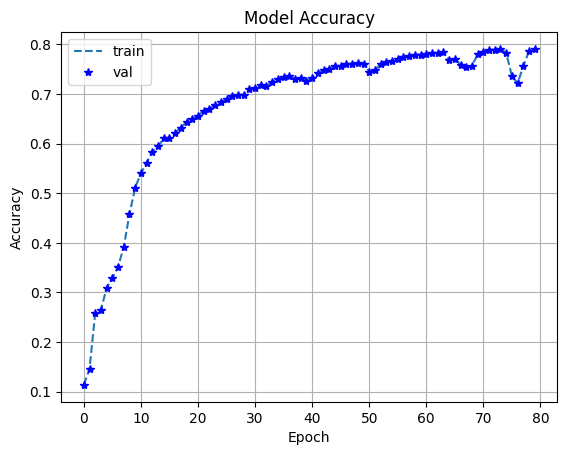

In [39]:
plt.plot(history.history['accuracy'], linestyle="dashed")
# plt.plot(history.history['val_accuracy'], linestyle="dashed")
plt.plot(history.history['accuracy'], "*", color="blue")
# plt.plot(history.history['val_accuracy'], "*", color="orange")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
# plt.savefig('Model_AccuracyS2PS')
plt.show()

# # **Testing Plots**

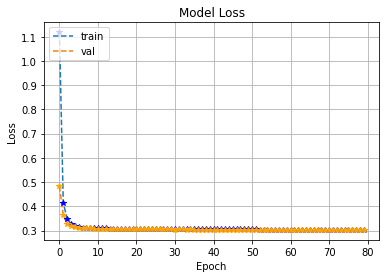

In [ ]:
plt.plot(history.history['loss'], linestyle="dashed")
# plt.plot(history.history['val_loss'], linestyle="dashed")
plt.plot(history.history['loss'],"*", color="blue")
plt.plot(history.history['val_loss'], "*", color="orange")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
# pp.savefig('Model_lossS2PS')
# plt.show()

In [40]:
model.save(("./drive/MyDrive/Advane_ANN/fullsetnopad50.h5"))

In [42]:
model =  keras.models.load_model("./drive/MyDrive/Advane_ANN/fullsetnopad50.h5")

In [43]:
output = model.predict(X*255)

12/12 [==============================] - 5s 366ms/step


In [44]:
output.shape

(361, 64, 64, 32)

In [45]:
output = np.array(output)

In [46]:
model_image = reconstruct_image(patches = output, image_size= stacked.shape, block_size = (64, 64),stride = 24)

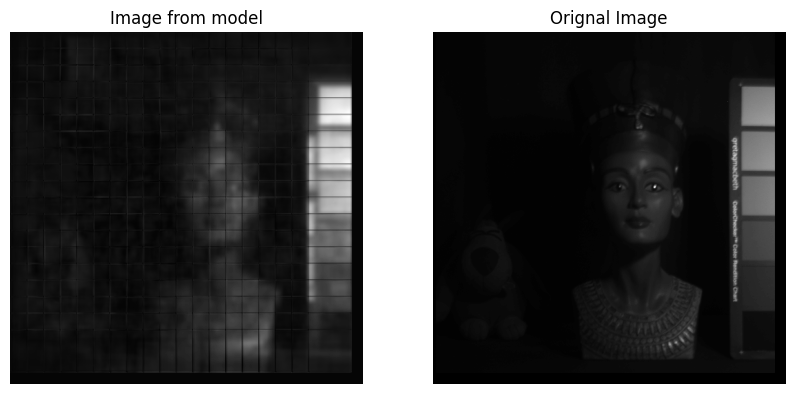

In [54]:
image_no = 6
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(model_image[:,:,image_no],cmap='gray')
ax1.axis('off')
ax2.set_title('Orignal Image')
ax2.imshow(orignal_image[:,:,image_no],cmap='gray')
ax2.axis('off')
ax1.set_title('Image from model')
plt.show()

In [8]:
# mymodel = keras.models.load_model("./drive/MyDrive/Advane_ANN/fullsetfinal50.h5") 

In [13]:
# np.array(mymodel.trainable_variables,dtype=object).shape

(10,)

In [ ]:
discriminator = keras.Sequential(
    [
        
       layers.Input((64*64*35)),
       layers.Dense((64*64*35)),
       layers.Reshape((64, 64, 35)),

        layers.Conv2D(filters = 32,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #shape(batch_size, 62, 62, 32).
        
        layers.Conv2D(filters = 64,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 60, 60, 64).

        layers.Conv2D(filters = 64,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 58, 58, 64).

        layers.Conv2D(filters = 128,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 56, 56, 128).
        
        layers.Reshape((112 ,112 ,32)),
        
        layers.Conv2D(filters = 32,kernel_size = (49,49),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 64, 64, 32).
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        layers.Input((100,)),
        layers.Dense(64*64*35),
        layers.Reshape((64, 64, 35)),

        layers.Conv2D(filters = 32,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #shape(batch_size, 62, 62, 32).
        
        layers.Conv2D(filters = 64,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 60, 60, 64).

        layers.Conv2D(filters = 64,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 58, 58, 64).

        layers.Conv2D(filters = 128,kernel_size = (3,3),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 56, 56, 128).
        
        layers.Reshape((112 ,112 ,32)),
        
        layers.Conv2D(filters = 32,kernel_size = (49,49),strides=1,padding="valid",activation="LeakyReLU"),
        #(batch_size, 64, 64, 32).
    ],
    name="generator",
)

In [138]:
noise_dim = 100
# Define the discriminator loss function
def discriminator_loss(real_output, synthetic_output):
  real_loss = tf.kerasbinary_crossentropy(tf.ones_like(real_output), real_output)
  synthetic_loss = tf.kerasbinary_crossentropy(tf.zeros_like(synthetic_output), synthetic_output)
  total_loss = real_loss + synthetic_loss
  return total_loss

# Define the generator loss function
def generator_loss(synthetic_output):
  return tf.kerasbinary_crossentropy(tf.ones_like(synthetic_output), synthetic_output)

# Define the discriminator and generator optimizers
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.001)
generator_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Define the training loop
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    synthetic_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    synthetic_output = discriminator(synthetic_images, training=True)

    gen_loss = generator_loss(synthetic_output)
    disc_loss = discriminator_loss(real_output, synthetic_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [56]:
# EPOCHS = 50
# BATCH_SIZE = 64

# # Train the GAN

# for epoch in range(EPOCHS):
#   for images in X:
#     train_step(images)

In [60]:
pkl.dump(X, open(r"C:\Users\tause\Advance_ANN\Data_Varibales\X.pkl","wb"))
pkl.dump(y, open(r"C:\Users\tause\Advance_ANN\Data_Varibales\y.pkl","wb"))    

In [3]:
X = pkl.load(open(r"C:\Users\tause\Advance_ANN\Data_Varibales\X.pkl","rb"))
y = pkl.load(open(r"C:\Users\tause\Advance_ANN\Data_Varibales\y.pkl","rb"))